In [1]:
# Library imports
import sys
import os
from datetime import datetime, timedelta
import time
import numpy as np
import pandas as pd
import QuantLib as ql
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

os.getcwd()

'C:\\local\\Python\\myProjects\\PFE'

In [2]:
# Chemin vers les DLL 
VCPKG_BIN_PATH = "C:/local/Cpplibs/vcpkg/installed/x64-windows/bin"
QUANTLIB_BIN_PATH = "C:/local/C++/libraries/QuantLib-install/bin"
os.add_dll_directory(VCPKG_BIN_PATH)
os.add_dll_directory(QUANTLIB_BIN_PATH)
print("Chemins DLL ajoutés avec succès.")
print(f" -> {VCPKG_BIN_PATH}")
print(f" -> {QUANTLIB_BIN_PATH}")
module_path = os.path.join(os.getcwd(), 'modules')
if module_path not in sys.path:
    sys.path.insert(0, module_path)
    print(f"\nChemin du module '{module_path}' ajouté au sys.path.")

Chemins DLL ajoutés avec succès.
 -> C:/local/Cpplibs/vcpkg/installed/x64-windows/bin
 -> C:/local/C++/libraries/QuantLib-install/bin

Chemin du module 'C:\local\Python\myProjects\PFE\modules' ajouté au sys.path.


In [3]:
module_path = 'C:\\local\\Python\\myProjects\\PFE\\modules' 
if module_path not in sys.path:
    sys.path.insert(0, module_path)
try:
    from modules.utils import Utils, parse_instrument_name, parse_swaption_name
    from modules.discount_curve import DiscountCurve
    from modules.european_swaption import EuropeanSwaption
    from modules.calibration_problem import CalibrationProblem
    from modules.simulated_annealing import SimulatedAnnealing
    import fast_pricer
    print("SUCCESS: Custom modules (Utils, DiscountCurve, EuropeanSwaption, fast_pricer) imported!")
except ModuleNotFoundError as e:
    print(f"\nERROR importing custom modules: {e}")
except ImportError as e:
    print(f"\nERROR during import: {e}")

#  Matplotlib for inline plotting
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid') # Using a seaborn style for nicer plots



SUCCESS: Custom modules (Utils, DiscountCurve, EuropeanSwaption, fast_pricer) imported!


In [4]:
try:
    df = pd.read_csv('data/forward.csv')
    print(f"Successfully loaded data from '{'data/forward.csv'}'")
    print("Raw DataFrame head:")
    print(df.head(5)) 
except FileNotFoundError:
    print(f"ERROR: Data file not found at '{'data/forward.csv'}'. Please ensure it exists.")
    df = pd.DataFrame()


Successfully loaded data from 'data/forward.csv'
Raw DataFrame head:
   Unnamed: 0               Unnamed: 1      Unnamed: 2      Unnamed: 3  \
0         NaN                      NaN             NaN             NaN   
1         NaN                      NaN             NaN             NaN   
2         NaN  S0042FS 1Y1Y BLC Curncy             NaN             NaN   
3       Dates                  PX_LAST  VOLATILITY_30D  VOLATILITY_10D   
4  07/05/2025                   3.1336           51.06           43.16   

                Unnamed: 4      Unnamed: 5      Unnamed: 6  \
0                      NaN             NaN             NaN   
1                      NaN             NaN             NaN   
2  S0042FS 5Y5Y BLC Curncy             NaN             NaN   
3                  PX_LAST  VOLATILITY_30D  VOLATILITY_10D   
4                   3.9646           29.06           20.11   

                Unnamed: 7      Unnamed: 8      Unnamed: 9  ...  \
0                      NaN             NaN    

In [5]:
#Data cleaning and transformation routine
a = df.iloc[2]
a.dropna()

tickers = []
for item in a:
    try:
        words = str(item).split()
        if len(words) >= 2:
            tickers.append(words[1])
    except AttributeError:
        pass
# Delete the first three rows
df = df.iloc[4:]

del a
del item
del words

#checking the date patterns
date_pattern = r'^\d{2}-\d{2}-\d{4}$'
format_bool = df[df.columns[0]].astype(str).str.match(date_pattern)

del format_bool
del date_pattern

# Convert the first column to datetime objects
try:
    df[df.columns[0]] = pd.to_datetime(df[df.columns[0]], format='%d/%m/%Y')
except ValueError:
    print("Error converting to datetime. recheck the format of the date column.")

# Set the first column as the index
df = df.set_index(df.columns[0])
df_extended = df.copy()
# Get the column indexes divisible by 3
selected_columns = [i for i in range(len(df.columns)) if i % 3 == 0]

# Select the corresponding columns from the DataFrame and devide by 100 to get rates
df = df.iloc[:, selected_columns].apply(pd.to_numeric)/100
df_extended.apply(pd.to_numeric)

# Now df contains only the columns with rates without volatilities
df.columns = tickers

# Check for NaN values in the DataFrame
#print(df.isnull().values.any())

# get a summary of NaN values per column
#print(df.isnull().sum())

#df.columns


--- Début du prétraitement des données ---
DataFrame transformé et prêt pour l'analyse (`df_analysis`):
  Ticker      Taux  Volatilite_10J  Volatilite_30J  Forward_Years  \
0   1Y1Y  0.031336           51.06           43.16            1.0   
1   5Y5Y  0.039646           29.06           20.11            5.0   
2   2Y1Y  0.032393           42.07           35.06            2.0   
3   2Y1M  0.031831           41.55           34.03            2.0   
4   1Y1M  0.031381           50.74           43.07            1.0   

   Tenor_Years  Maturity_Years  
0     1.000000        2.000000  
1     5.000000       10.000000  
2     1.000000        3.000000  
3     0.083333        2.083333  
4     0.083333        1.083333  
Nombre d'instruments dans df_analysis: 25

--- Fin du prétraitement ---


### Étape 3: Analyse Statistique Univariée ###

Statistiques descriptives des variables clés :
            Taux  Volatilite_10J  Volatilite_30J
count  25.000000       25.000000       25.000000
mean    0.03568

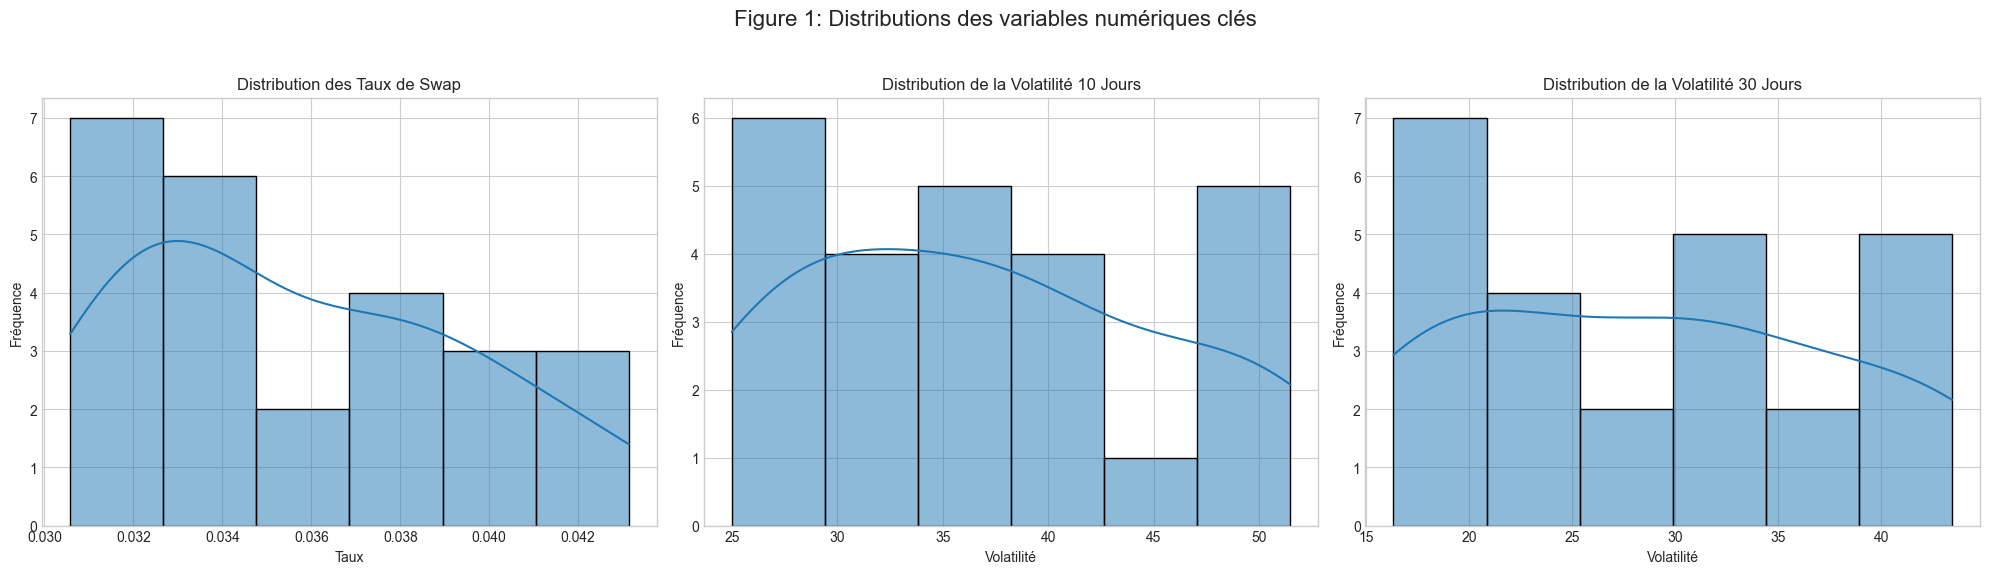



### Étape 4: Visualisation de la Structure de la Courbe des Taux Forward ###



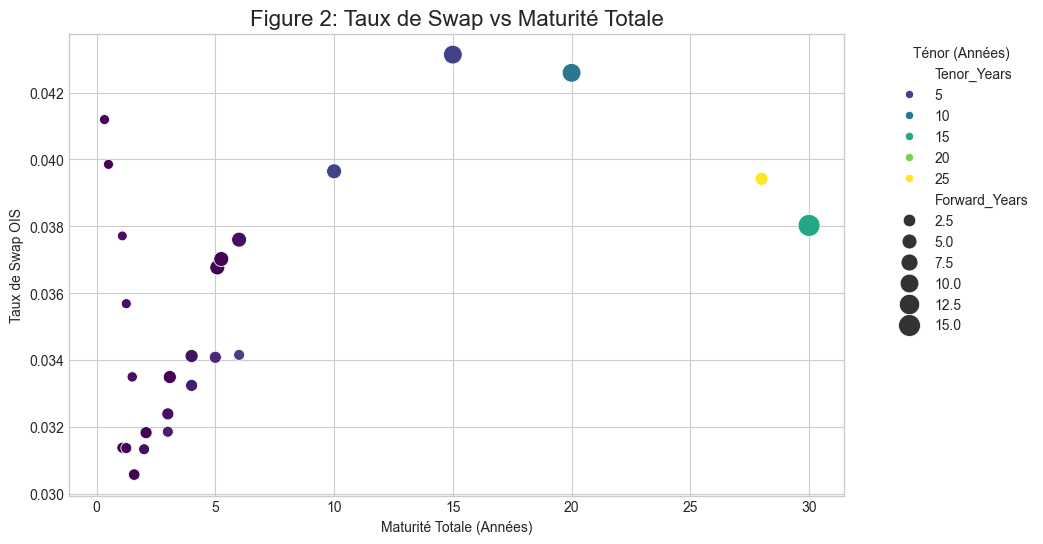



### Étape 5: Analyse de la Volatilité et des Corrélations ###



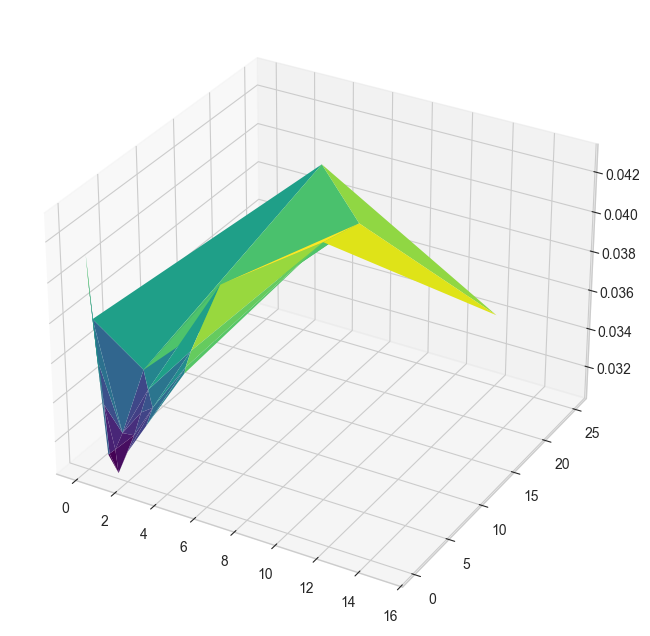

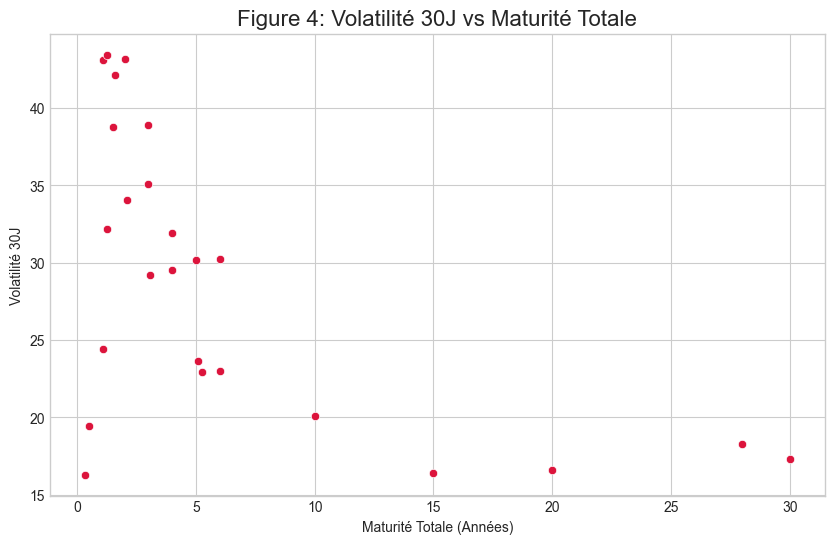

Matrice de corrélation des variables quantitatives :
                    Taux  Volatilite_10J  Volatilite_30J  Forward_Years  \
Taux            1.000000       -0.894531       -0.936387       0.524149   
Volatilite_10J -0.894531        1.000000        0.986629      -0.634845   
Volatilite_30J -0.936387        0.986629        1.000000      -0.574267   
Forward_Years   0.524149       -0.634845       -0.574267       1.000000   
Tenor_Years     0.426900       -0.513420       -0.468624       0.496507   
Maturity_Years  0.532842       -0.642825       -0.584425       0.793823   

                Tenor_Years  Maturity_Years  
Taux               0.426900        0.532842  
Volatilite_10J    -0.513420       -0.642825  
Volatilite_30J    -0.468624       -0.584425  
Forward_Years      0.496507        0.793823  
Tenor_Years        1.000000        0.922032  
Maturity_Years     0.922032        1.000000  


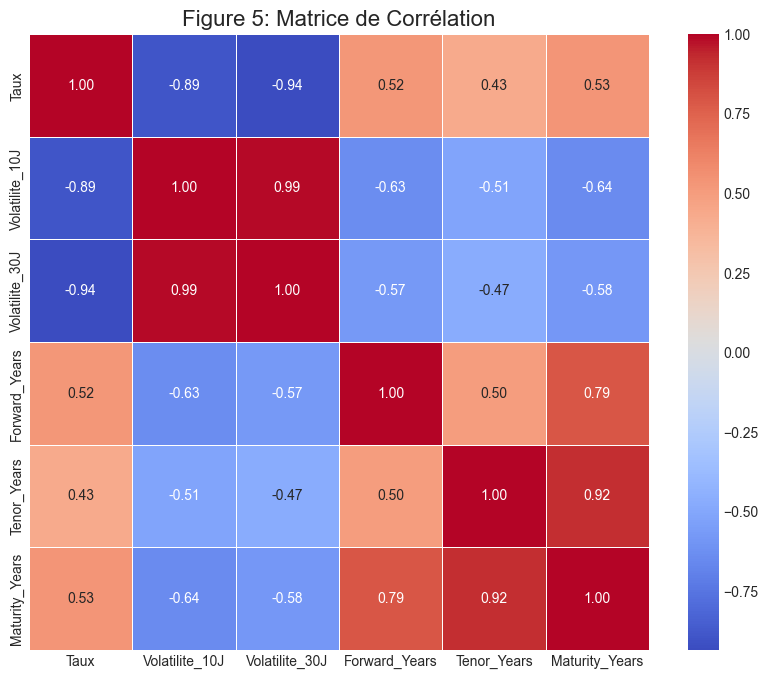

In [6]:
### ÉTAPE DE PRÉTRAITEMENT 

print("\n--- Début du prétraitement des données ---")

# 1. Sélectionner la ligne de données la plus récente (première ligne de df_extended)
latest_data_row = df_extended.iloc[0].apply(pd.to_numeric)

# 2. Itérer et reconstruire le DataFrame 
data_records = []
for instrument_idx, ticker_name_cleaned in enumerate(tickers):
    # ticker_name_cleaned est du type "3M1Y", "1Y10Y", etc.
    forward_months, tenor_months = parse_instrument_name(ticker_name_cleaned)

    # Vérifier si le parsing a réussi
    if forward_months is None or tenor_months is None:
        print(f"Skipping instrument due to parsing error: {ticker_name_cleaned}")
        continue

    # Déterminer les indices des colonnes dans df_extended pour cet instrument
    rate_col_idx_in_df_extended = instrument_idx * 3
    vol10_col_idx_in_df_extended = instrument_idx * 3 + 1
    vol30_col_idx_in_df_extended = instrument_idx * 3 + 2
    
    # Extraire les données de la ligne
    # Les taux sont stockés multipliés par 100 dans df_extended
    rate = latest_data_row.iloc[rate_col_idx_in_df_extended] / 100.0
    vol10 = latest_data_row.iloc[vol10_col_idx_in_df_extended]
    vol30 = latest_data_row.iloc[vol30_col_idx_in_df_extended]

    record = {
        'Ticker': ticker_name_cleaned, # Utilise le ticker nettoyé (ex: "3M1Y")
        'Taux': rate,
        'Volatilite_10J': vol10,
        'Volatilite_30J': vol30,
        'Forward_Years': forward_months / 12.0,
        'Tenor_Years': tenor_months / 12.0
    }
    data_records.append(record)

# 3. Créer le DataFrame final et la colonne de maturité
   
df_analysis = pd.DataFrame(data_records) 
df_analysis['Maturity_Years'] = df_analysis['Forward_Years'] + df_analysis['Tenor_Years']

print("DataFrame transformé et prêt pour l'analyse (`df_analysis`):")
print(df_analysis.head())
print(f"Nombre d'instruments dans df_analysis: {len(df_analysis)}")
print("\n--- Fin du prétraitement ---")


### Étape 3: Analyse Statistique Univariée
print("\n\n### Étape 3: Analyse Statistique Univariée ###\n")
print("Statistiques descriptives des variables clés :")
stats_desc = df_analysis[['Taux', 'Volatilite_10J', 'Volatilite_30J']].describe()
print(stats_desc)

plt.style.use('seaborn-v0_8-whitegrid') 
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.histplot(df_analysis['Taux'], kde=True, ax=axes[0]).set(title='Distribution des Taux de Swap', xlabel='Taux', ylabel='Fréquence')
sns.histplot(df_analysis['Volatilite_10J'], kde=True, ax=axes[1]).set(title='Distribution de la Volatilité 10 Jours', xlabel='Volatilité', ylabel='Fréquence')
sns.histplot(df_analysis['Volatilite_30J'], kde=True, ax=axes[2]).set(title='Distribution de la Volatilité 30 Jours', xlabel='Volatilité', ylabel='Fréquence')

plt.suptitle('Figure 1: Distributions des variables numériques clés', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Étape 4: Visualisation de la Structure de la Courbe des Taux Forward
print("\n\n### Étape 4: Visualisation de la Structure de la Courbe des Taux Forward ###\n")

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_analysis, x='Maturity_Years', y='Taux', hue='Tenor_Years', size='Forward_Years', sizes=(50, 250), palette='viridis')
plt.title('Figure 2: Taux de Swap vs Maturité Totale', fontsize=16)
plt.xlabel('Maturité Totale (Années)')
plt.ylabel('Taux de Swap OIS')
plt.legend(title='Ténor (Années)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
# Utiliser plot_trisurf 
ax.plot_trisurf(df_analysis['Forward_Years'], df_analysis['Tenor_Years'], df_analysis['Taux'], cmap='viridis', edgecolor='none')

### Étape 5: Analyse de la Volatilité et des Corrélations
print("\n\n### Étape 5: Analyse de la Volatilité et des Corrélations ###\n")

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_analysis, x='Maturity_Years', y='Volatilite_30J', color='crimson')
plt.title('Figure 4: Volatilité 30J vs Maturité Totale', fontsize=16)
plt.xlabel('Maturité Totale (Années)')
plt.ylabel('Volatilité 30J')
plt.grid(True)
plt.show()

print("Matrice de corrélation des variables quantitatives :")
# Sélection des colonnes numériques pour la corrélation
cols_for_corr = ['Taux', 'Volatilite_10J', 'Volatilite_30J', 'Forward_Years', 'Tenor_Years', 'Maturity_Years']
correlation_matrix = df_analysis[cols_for_corr].corr()
print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Figure 5: Matrice de Corrélation', fontsize=16)
plt.show()


In [7]:
# Initialisation de la courbe d'actualisation
fwd_starts = [12, 60, 24, 24, 12, 120, 120, 24, 36, 36, 60, 60, 3, 36, 12, 24, 180, 18, 1, 3, 6, 12, 60, 12, 3]
tenors = [12, 60, 12,  1,  1,  60, 120, 24, 12,  1,  1, 12, 3, 300,  3, 36, 180,  1, 12, 12, 12, 24,  3, 60, 1]

#This valuation date is only set once, all subsequent calculations are done based on this date
valuation_date = pd.Timestamp('2022-03-02')

#ql.Date equivalent (needed for class definitions where ql.Date object is more convenient)
vdate = ql.Date(valuation_date.day, valuation_date.month, valuation_date.year)

dc = DiscountCurve(df, fwd_starts, tenors)

start_time_bootstrapping = time.time()
ql.Settings.instance().evaluationDate = vdate
dc.build_curve(valuation_date, verbose=False)
bootstrapping_time = time.time() - start_time_bootstrapping
print(f"\nTemps d'exécution du Bootstrapping: {bootstrapping_time:.4f} secondes")




Temps d'exécution du Bootstrapping: 1.4803 secondes


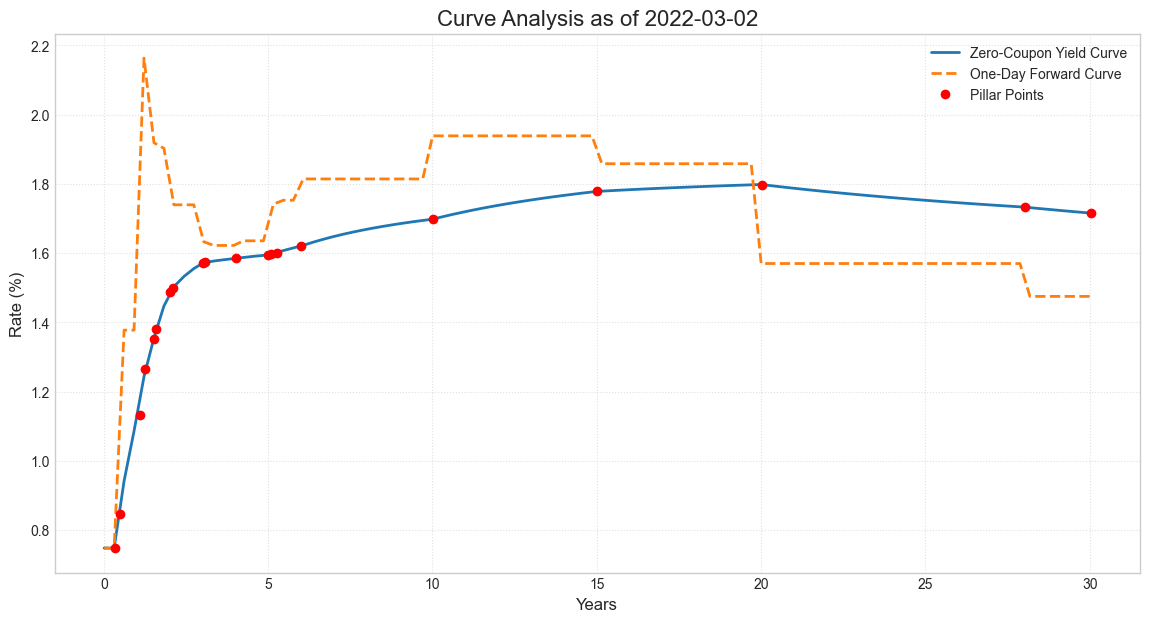

In [8]:
dc.plot_all_curves()

In [9]:
validation_results = dc.validate_market_prices()
print(validation_results.to_string(formatters={'Difference': '{:.2e}'.format}))


🕵️  Validation by Market Prices:
✅ Success! The curve perfectly reprices all input instruments.
       Instrument  Market Rate  Implied Rate Difference
0    Instrument 1     0.011739      0.011739   4.23e-15
1    Instrument 2     0.008231      0.008231   2.98e-14
2    Instrument 3     0.009476      0.009476  -3.95e-13
3    Instrument 4     0.014056      0.014056  -1.47e-15
4    Instrument 5     0.016293      0.016293   2.35e-15
5    Instrument 6     0.018905      0.018905  -1.56e-15
6    Instrument 7     0.018212      0.018212  -1.21e-16
7    Instrument 8     0.017384      0.017384   1.12e-14
8    Instrument 9     0.019202      0.019202   5.74e-13
9   Instrument 10     0.017487      0.017487   7.11e-14
10  Instrument 11     0.016961      0.016961  -2.68e-15
11  Instrument 12     0.016806      0.016806   4.21e-14
12  Instrument 13     0.016339      0.016339   1.56e-15
13  Instrument 14     0.017763      0.017763  -1.14e-14
14  Instrument 15     0.017296      0.017296   1.31e-14
15  Inst

In [10]:
# Calculate european swaption prices
price_hw1_test = fast_pricer.price_hw1f(
    py_discount_curve=dc,
    val_day=vdate.dayOfMonth(),
    val_month=vdate.month(),
    val_year=vdate.year(),
    expiry_months=24,
    tenor_years=10,
    strike=0.04,
    a_x=0.03,
    sigma_x=0.01,
    is_payer=True
)

print(f"Prix de la swaption (HW1F, C++ engine): {price_hw1_test:.6f}")

Prix de la swaption (HW1F, C++ engine): 0.001659


In [11]:
%timeit fast_pricer.price_hw1f(py_discount_curve=dc,val_day=vdate.dayOfMonth(),val_month=vdate.month(),val_year=vdate.year(),expiry_months=24,tenor_years=10,strike=0.04,a_x=0.03,sigma_x=0.01,is_payer=True)

555 μs ± 12.8 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [12]:
# --- 5. Test and Time HW2F ---
print("Timing HW2F (with default payment_frequency = 1)")
%timeit fast_pricer.price_hw2f(py_discount_curve=dc, val_day=vdate.dayOfMonth(), val_month=vdate.month(), val_year=vdate.year(), expiry_months=2, tenor_years=10, strike=0.04, a_x=0.03, sigma_x=0.01, a_y=0.05, sigma_y=0.015, rho=-0.5, is_payer=True)
print("-" * 40)


# --- 6. Get a single result to verify the value ---
print("Verifying a single price calculation...")
final_price = fast_pricer.price_hw2f(
    py_discount_curve=dc,
    val_day=vdate.dayOfMonth(),
    val_month=vdate.month(),
    val_year=vdate.year(),
    expiry_months=24,
    tenor_years=10,
    strike=0.04,
    a_x=0.03, sigma_x=0.01,
    a_y=0.05, sigma_y=0.015, rho=-0.5,
    is_payer=True
)
print(f"Calculated HW2F Price: {final_price:.8f}")

Timing HW2F (with default payment_frequency = 1)
935 μs ± 17.6 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
----------------------------------------
Verifying a single price calculation...
Calculated HW2F Price: 0.00421847


In [13]:
try:
    ds = pd.read_csv('data/swaptions.csv')
    print(f"Successfully loaded data from '{'data/swaptions.csv'}'")
    print("Raw DataFrame head:")
    print(ds.head(5)) 
except FileNotFoundError:
    print(f"ERROR: Data file not found at '{'data/swaptions.csv'}'. Please ensure it exists.")
    ds = pd.DataFrame()

Successfully loaded data from 'data/swaptions.csv'
Raw DataFrame head:
  Unnamed: 0       Unnamed: 1  Unnamed: 2  Unnamed: 3       Unnamed: 4  \
0        NaN              NaN         NaN         NaN              NaN   
1        NaN              NaN         NaN         NaN              NaN   
2        NaN  USSN0C10 Curncy         NaN         NaN  USSN0110 Curncy   
3  6/12/2023          116.268       36.99       33.23           114.39   
4  5/12/2023          116.268       36.99       33.23           114.39   

   Unnamed: 5  Unnamed: 6       Unnamed: 7  Unnamed: 8  Unnamed: 9  \
0         NaN         NaN              NaN         NaN         NaN   
1         NaN         NaN              NaN         NaN         NaN   
2         NaN         NaN  USSN0A10 Curncy         NaN         NaN   
3       41.33        61.6          118.608       50.50       47.75   
4       41.33        61.6            115.4       49.53       45.86   

      Unnamed: 10  Unnamed: 11  Unnamed: 12     Unnamed: 13  Un

In [14]:
#Data cleaning and transformation routine
a = ds.iloc[2]
a.dropna()

tickers_ = []
for item in a:
    try:
        words = str(item).split()
        if len(words) >= 2:
            tickers_.append(words[0])
    except AttributeError:
        pass
# Delete the first three rows
ds = ds.iloc[4:]

del a
del item
del words

#checking the date patterns
date_pattern = r'^\d{2}-\d{2}-\d{4}$'
format_bool = ds[ds.columns[0]].astype(str).str.match(date_pattern)

del format_bool
del date_pattern

# Convert the first column to datetime objects
try:
    ds[ds.columns[0]] = pd.to_datetime(ds[ds.columns[0]], format='%d/%m/%Y')
except ValueError:
    print("Error converting to datetime. recheck the format of the date column.")

# Set the first column as the index
ds = ds.set_index(ds.columns[0])
ds_extended = ds.copy()
# Get the column indexes divisible by 3
selected_columns = [i for i in range(len(ds.columns)) if i % 3 == 0]

# Select the corresponding columns from the DataFrame and devide by 10000(quotes in BasisPoints) to get rates
ds = ds.iloc[:, selected_columns].apply(pd.to_numeric)/10000
ds_extended.apply(pd.to_numeric)

# Now df contains only the columns with rates without volatilities
ds.columns = tickers_
ds = ds.dropna()
ds_extended= ds_extended.dropna()
# Check for NaN values in the DataFrame
if ds.isnull().values.any():
    print("there are still nan values")
    # get a summary of NaN values per column
    print(ds.isnull().sum())
else:
    print("Cleaning routine was successful")
    


Cleaning routine was successful


In [15]:
# --- Helper Function for Plotting and Saving (shoud be moved to utils, stays here for now)---
def plot_and_save_convergence(history, temp, alpha, cost, model_name, output_dir):
    """Creates, saves, and closes a convergence plot for a single SA run."""
    # Create a unique, descriptive filename
    filename = f"{model_name}_T{temp}_alpha{alpha}.png"
    filepath = os.path.join(output_dir, filename)

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(history['cost'], label='Current Cost', alpha=0.6)
    ax.plot(history['best_cost'], label='Best Cost Found', color='red', linewidth=2, linestyle='--')
    
    title = (f'{model_name} Convergence\n'
             f'Initial Temp: {temp}, Alpha: {alpha}\n'
             f'Final Cost (SSRE): {cost:.8f}')
    ax.set_title(title)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Cost (SSRE)')
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Save the figure to the specified directory
    plt.savefig(filepath)
    # Close the figure to free up memory and prevent it from displaying inline
    plt.close(fig)
    
    return filepath


In [16]:
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True) 
print(f"--- Setting up for Hyperparameter Search. Plots will be saved to '{output_dir}/' ---")


--- Setting up for Hyperparameter Search. Plots will be saved to 'outputs/' ---


In [17]:
print("--- Setting up for Hyperparameter Search ---")

print(f"--- Setting up for Hyperparameter Search. Plots will be saved to '{output_dir}/' ---")

# --- 1. Prepare Data and Instrument Metadata ---
instrument_list = [
    {'name': 'USSN0C10', 'expiry_months': 3,  'tenor_years': 10},
    {'name': 'USSN0110', 'expiry_months': 12, 'tenor_years': 10},
    {'name': 'USSN0A10', 'expiry_months': 1,  'tenor_years': 10},
    {'name': 'USSN011',  'expiry_months': 12, 'tenor_years': 1},
    {'name': 'USSN0C2',  'expiry_months': 3,  'tenor_years': 2},
    {'name': 'USSN0210', 'expiry_months': 24, 'tenor_years': 10},
]
ds = ds.sort_index() # Ensure index is sorted
market_vols_for_date = ds.asof(valuation_date)

# --- 2. Define the Hyperparameter Search Space ---
# The algorithm is a metaheuristic for global optimization in large search spaces. 
initial_temps = [1.0, 0.5, 0.1, 0.01]
alphas = [0.99, 0.95, 0.90] # We will use a geometric cooling schedule. 

print(f"Search Grid - Initial Temps: {initial_temps}")
print(f"Search Grid - Alphas (Cooling Factor): {alphas}")
print(f"Total combinations to test: {len(initial_temps) * len(alphas)}")


# --- 3. Set up Calibration Problems (one for each model) ---
# The cost function to be minimized is the Sum of Squared Relative Errors (SSRE). 
print("\nPreparing calibration problems...")
hw1f_problem = CalibrationProblem(instrument_list, market_vols_for_date, dc, model_type='HW1F')
hw2f_problem = CalibrationProblem(instrument_list, market_vols_for_date, dc, model_type='HW2F')


# --- 4. Initialize variables to track the best results for each model ---
best_overall_cost_hw1f = float('inf')
best_hyperparams_hw1f = {}
best_model_params_hw1f = None

best_overall_cost_hw2f = float('inf')
best_hyperparams_hw2f = {}
best_model_params_hw2f = None

total_start_time = time.time()


# --- 5. Run the Grid Search Loop for Both Models ---
for temp in initial_temps:
    for alpha in alphas:
        print("-" * 60)
        print(f"Testing Hyperparameters: Initial Temp = {temp}, Alpha = {alpha}")
        print("-" * 60)

        # --- HW1F Calibration Run ---
        print("  -> Running HW1F Calibration...")
        initial_params_hw1f = [0.1, 0.01]
        sa_solver_hw1f = SimulatedAnnealing(problem=hw1f_problem, initial_temp=temp, final_temp=1e-7, alpha=alpha, scale_factor=0.05)
        
        # New solutions are generated by adding a random Gaussian perturbation. 
        params_1f, cost_1f, history_1f = sa_solver_hw1f.calibrate(initial_params_hw1f, verbose=False)
        print(f"     HW1F Run Complete. Final Cost: {cost_1f:.8f}")

        # the plotting function >>>
        plot_path_1f = plot_and_save_convergence(history_1f, temp, alpha, cost_1f, 'HW1F', output_dir)
        print(f"     -> Plot saved to {plot_path_1f}")

        if cost_1f < best_overall_cost_hw1f:
            print("     *** New Best Result for HW1F Found! ***")
            best_overall_cost_hw1f = cost_1f
            best_hyperparams_hw1f = {'initial_temp': temp, 'alpha': alpha}
            best_model_params_hw1f = params_1f

        # --- HW2F Calibration Run ---
        print("  -> Running HW2F Calibration...")
        initial_params_hw2f = [0.1, 0.01, 0.05, 0.015, -0.5]
        sa_solver_hw2f = SimulatedAnnealing(problem=hw2f_problem, initial_temp=temp, final_temp=1e-7, alpha=alpha, scale_factor=0.05)
        
        params_2f, cost_2f, history_2f = sa_solver_hw2f.calibrate(initial_params_hw2f, verbose=False)
        print(f"     HW2F Run Complete. Final Cost: {cost_2f:.8f}")

        # the plotting function
        plot_path_2f = plot_and_save_convergence(history_2f, temp, alpha, cost_2f, 'HW2F', output_dir)
        print(f"     -> Plot saved to {plot_path_2f}")

        if cost_2f < best_overall_cost_hw2f:
            print("     *** New Best Result for HW2F Found! ***")
            best_overall_cost_hw2f = cost_2f
            best_hyperparams_hw2f = {'initial_temp': temp, 'alpha': alpha}
            best_model_params_hw2f = params_2f

total_end_time = time.time()


# --- 6. Print the Final Report ---
print("\n" + "="*60)
print(" " * 17 + "HYPERPARAMETER SEARCH COMPLETE")
print("="*60)
print(f"Total execution time: {total_end_time - total_start_time:.2f} seconds")

print("\n--- Optimal Results for HW1F ---")
print(f"Lowest Cost (SSRE): {best_overall_cost_hw1f:.8f}")
print("Best Hyperparameters:")
print(f"  - Initial Temperature: {best_hyperparams_hw1f.get('initial_temp')}")
print(f"  - Alpha (Cooling Factor): {best_hyperparams_hw1f.get('alpha')}")
print("Optimal Model Parameters found with these settings:")
print(f"  - (a, sigma): {np.round(best_model_params_hw1f, 5) if best_model_params_hw1f is not None else 'N/A'}")

print("\n--- Optimal Results for HW2F ---")
print(f"Lowest Cost (SSRE): {best_overall_cost_hw2f:.8f}")
print("Best Hyperparameters:")
print(f"  - Initial Temperature: {best_hyperparams_hw2f.get('initial_temp')}")
print(f"  - Alpha (Cooling Factor): {best_hyperparams_hw2f.get('alpha')}")
print("Optimal Model Parameters found with these settings:")
print(f"  - (a_x, sigma_x, a_y, sigma_y, rho): {np.round(best_model_params_hw2f, 5) if best_model_params_hw2f is not None else 'N/A'}")


--- Setting up for Hyperparameter Search ---
--- Setting up for Hyperparameter Search. Plots will be saved to 'outputs/' ---
Search Grid - Initial Temps: [1.0, 0.5, 0.1, 0.01]
Search Grid - Alphas (Cooling Factor): [0.99, 0.95, 0.9]
Total combinations to test: 12

Preparing calibration problems...
------------------------------------------------------------
Testing Hyperparameters: Initial Temp = 1.0, Alpha = 0.99
------------------------------------------------------------
  -> Running HW1F Calibration...
     HW1F Run Complete. Final Cost: 1.60897701
     -> Plot saved to outputs\HW1F_T1.0_alpha0.99.png
     *** New Best Result for HW1F Found! ***
  -> Running HW2F Calibration...
     HW2F Run Complete. Final Cost: 1.48756774
     -> Plot saved to outputs\HW2F_T1.0_alpha0.99.png
     *** New Best Result for HW2F Found! ***
------------------------------------------------------------
Testing Hyperparameters: Initial Temp = 1.0, Alpha = 0.95
--------------------------------------------

In [ ]:
print("\n" + "="*60)
print(" " * 12 + "VALORISATION DE SWAPTION BERMUDIENNE AVEC LSM")
print("="*60)
exercise_times = [1.0, 2.0, 3.0, 4.0, 5.0]
T_bermudan = exercise_times[-1] 

# Paramètres de la simulation Monte Carlo
num_paths_regression = 20000
num_steps_regression = int(T_bermudan * 12) 

# Paramètres du swap sous-jacent à la swaption bermudienne
bermudan_strike = 0.045
payment_frequency = 1 # Annuel
is_payer_swaption = True

# Créer les objets
hw1f_params = fast_pricer.HW1F_Params()
hw1f_params.a = best_params_hw1f[0]
hw1f_params.sigma = best_params_hw1f[1]

hw2f_params = fast_pricer.HW2F_Params()
(hw2f_params.a_x, hw2f_params.sigma_x, 
 hw2f_params.a_y, hw2f_params.sigma_y, 
 hw2f_params.rho) = best_params_hw2f


################################################################################
#                             VALORISATION AVEC HW1F                           #
################################################################################
print(f"\n--- Modèle HW1F | Paramètres: a={hw1f_params.a:.4f}, sigma={hw1f_params.sigma:.4f} ---")

# --- Étape A: Calcul de la politique d'exercice (Régression LSM) ---
print(f"Lancement de la régression LSM sur {num_paths_regression} chemins...")
start_time_reg = time.time()

# Appel à la fonction C++ surchargée pour HW1F
betas_hw1f = fast_pricer.run_lsm_regression(
    hw1f_params,
    dc,  # L'objet DiscountCurve de Python
    num_paths_regression,
    num_steps_regression,
    exercise_times,
    bermudan_strike,
    payment_frequency,
    is_payer_swaption
)
end_time_reg = time.time()
print(f"Régression HW1F terminée en {end_time_reg - start_time_reg:.2f} secondes.")

# --- Étape B: Valorisation avec la politique d'exercice optimale ---
num_paths_pricing = 50000
num_steps_pricing = int(T_bermudan * 12)

print(f"\nLancement de la valorisation LSM sur {num_paths_pricing} chemins...")
start_time_price = time.time()

# Appel à la fonction de pricing C++
price_hw1f_lsm = fast_pricer.price_with_lsm_policy(
    hw1f_params,
    betas_hw1f,
    dc,
    num_paths_pricing,
    num_steps_pricing,
    exercise_times,
    bermudan_strike,
    payment_frequency,
    is_payer_swaption
)
end_time_price = time.time()
print(f"Valorisation HW1F terminée en {end_time_price - start_time_price:.2f} secondes.")
print("-" * 40)
print(f"Prix de la Swaption Bermudienne (HW1F, Moteur LSM C++): {price_hw1f_lsm:.6f}")
print("-" * 40)


################################################################################
#                             VALORISATION AVEC HW2F                           #
################################################################################
print(f"\n--- Modèle HW2F | Paramètres: a_x={hw2f_params.a_x:.4f}, sigma_x={hw2f_params.sigma_x:.4f}, a_y={hw2f_params.a_y:.4f}, sigma_y={hw2f_params.sigma_y:.4f}, rho={hw2f_params.rho:.4f} ---")

# --- Étape A: Calcul de la politique d'exercice (Régression LSM) ---
print(f"Lancement de la régression LSM sur {num_paths_regression} chemins...")
start_time_reg = time.time()

# Appel à la fonction C++ surchargée pour HW2F
betas_hw2f = fast_pricer.run_lsm_regression(
    hw2f_params,
    dc,
    num_paths_regression,
    num_steps_regression,
    exercise_times,
    bermudan_strike,
    payment_frequency,
    is_payer_swaption
)
end_time_reg = time.time()
print(f"Régression HW2F terminée en {end_time_reg - start_time_reg:.2f} secondes.")

# --- Étape B: Valorisation avec la politique d'exercice optimale ---
print(f"\nLancement de la valorisation LSM sur {num_paths_pricing} chemins...")
start_time_price = time.time()

price_hw2f_lsm = fast_pricer.price_with_lsm_policy(
    hw2f_params,
    betas_hw2f,
    dc,
    num_paths_pricing,
    num_steps_pricing,
    exercise_times,
    bermudan_strike,
    payment_frequency,
    is_payer_swaption
)
end_time_price = time.time()
print(f"Valorisation HW2F terminée en {end_time_price - start_time_price:.2f} secondes.")
print("-" * 40)
print(f"Prix de la Swaption Bermudienne (HW2F, Moteur LSM C++): {price_hw2f_lsm:.6f}")
print("-" * 40)